# Pricing Spread Options with Python
*****

##About this notebook
Documention prepared by **Jesus Perez Colino**.
Version 0.1, Released 25/11/2014, Alpha.


- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: This technical note has as main goal to summarize the different methodologies to calculate an spread option, with the implementation in Python. 


- **Index**:

    0. About this notebook
    1. Spreads Options: General Framework
    2. Spread Options Valuation when $K=0$: Margrabe's Formula
    3. Spread Options Valuation when $K \neq 0$: Kirk's Formula
    4. Spread Options Valuation by Monte-Carlo Simulation


- **Reference**: [Rene Carmona and Valdo Durrleman "*Pricing and Hedging Spread Options*" SIAM Review Vol.45 No.4, pp627-685](http://www.princeton.edu/~rcarmona/download/fe/sirev.pdf)


- **Reproducibility conditions**: the content in this technical note can be reproduce in your computer under the following versions of the Python's packages: 


In [1]:
%matplotlib inline
import sys
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from scipy.stats import norm

print ' Reproducibility conditions for the Two-factor model'.center(80, '-')
print ' '
print ' Python Version: ' + sys.version
print ' Matplotlib Version:' + matplotlib.__version__
print ' Numpy Version: ' + np.__version__
print ' ' 
print '-'*80

-------------- Reproducibility conditions for the Two-factor model--------------
 
 Python Version: 2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)]
 Matplotlib Version:1.4.3
 Numpy Version: 1.9.2
 
--------------------------------------------------------------------------------


#Spread Options: General Framework

All over this technical note, we will consider a set of Brownian motions $B_{1}(t),B_{2}(t)$ with correlation $\rho$ on the probability space $(\Omega,\mathcal{F},\mathbb{P} )$ endowed with the natural (completed and right-continuous) filtration $\mathbb{F}=(\mathcal{F_t})_{t \geq T}$ generated by ${B_{1}(t),B_{2}(t)}$ up to some fixed time horizon $T>0$. 

We look at the classical setting where besides a riskless bank account with constant interest rate r, our arbitrage-free market model comprises two assets whose prices at time $t$ are denoted by $S_1(t)$ and $S_2(t)$. We assume that their risk-neutral price dynamics are given by the following stochastic differential equations:


\begin{equation}
\begin{array}{lll}
\frac{dS_1(t)}{S_1(t)}& =& \mu_1 (t,T) dt+\sigma_{1}(t,T)dB_{1}(t)\\
\end{array}
\end{equation}


\begin{equation}
\begin{array}{lll}
\frac{dS_2(t)}{S_2(t)}& =& \mu_2 (t,T) dt+\sigma_{2}(t,T)dB_{2}(t)\\
\end{array}
\end{equation}



where the volatilities $\sigma_1$ and $\sigma_2$ are positive constants and $B_1$ and $B_2$ are two Brownian motions with correlation $\rho$.

In any case, the value of an spread option $V$ at time $t$ of the spread option with date of maturity $T$ and strike $K$ is given by the following risk-neutral expectation:

\begin{equation}
\begin{array}{lll}
V(t,T)& =& \mathrm{e}^{-rT} \mathbb{E_Q}\{(S_1(T)-S_2(T)-K)^+\}\\
 & =& \mathrm{e}^{-rT} \mathbb{E_Q}\{(S_1(t)\mathrm{e}^{(\mu_1 - \sigma_1^2/2)T+\sigma_1 B_1(T) }-S_2(t)\mathrm{e}^{(\mu_2 - \sigma_2^2/2)T+\sigma_2 B_2(T) }-K)^+\}\\
 & =& \mathrm{e}^{-rT} \int \int (S_1(t)\mathrm{e}^{(\mu_1 - \sigma_1^2/2)T+\sigma_1 B_1(T) }-S_2(t)\mathrm{e}^{(\mu_2 - \sigma_2^2/2)T+\sigma_2 B_2(T) }-K)^+ \phi_T (B_1,B_2) dB_1 dB_2\\
\end{array}
\end{equation}

which shows that the value of the spread options $V(t,T)$ is given by the double integral of a function of two variables with respect to a bivariate Gaussian distribution, namely the joint distribution of $B_1(T)$ and $B_2(T)$. 


In [2]:
class SpreadOption(object):
    
    ''' Class for valuation of European Spreads Options (Calls/P.uts).
    S1_t : float : initial forward price/index level
    S2_t : float : initial forward price/index level
    K : float : strike price
    T : float : maturity (in year fractions)
    r : float : constant risk-free short rate
    vol1 : float : volatility factor in diffusion term (std)
    vol2 : float : volatility factor in diffusion term (std)
    rho : float: 
    CallPut : integer : 1 for a Call, and -1 for a Put
    '''
    
    def __init__(self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut, model):
        try:
            
            self.S1_t = float(S1_t)
            self.S2_t = float(S2_t)
            self.K = float(K)
            self.T = float(T)
            self.r = float(r)
            self.vol1 = float(vol1)
            self.vol2 = float(vol2)
            self.rho = float(rho)
            self.CallPut = int(CallPut)
            self.model = str(model)
            
            if T < 0 or r < 0 or S1_t < 0 or S2_t < 0:
                raise ValueError('Negative inputs not allowed.')
            if vol1 < 0 or vol2 < 0:
                raise ValueError('Negative volatilities are not allowed.')
            if rho > 1 or rho < -1:
                raise ValueError('Correlation out of range')
            if CallPut != 1 and CallPut != -1:
                raise ValueError('For a Call: CallPut=1, or -1 for a Put')
                
        except ValueError: 
            print('Error passing spread option inputs')
        
    def getmodel(self):
        return self.model
    
    def __str__(self):
        return "This SpreadOption is solved using {0}".format(self.getmodel())


Unfortunately, except in the case of an exchange option (i.e., an option with strike K = 0), the price of the spread option cannot be given by a formula in closed form.

# Spread Options Valuation when $K=0$: Margrabe's Formula

The most common treatment of spread options is usually restricted to the special case $K = 0$ because
when the distributions of the underlying $S_1$ and $S_2$ are log-normal, this is the only case for
which one has a solution in a closed form a la `Black-Scholes` for the price of the spread option with
zero strike. This formula was first derived by Margrabe as early as in 1978, and it bears his
name:


\begin{equation}
\begin{array}{lll}
V(t,T)_{Margrabe}& =& S_2(t)\phi(d_1) - S_1(t)\phi(d_0)\\
\end{array}
\end{equation}
where 
\begin{equation}
\begin{array}{lll}
d_0 & =& \frac{\ln(S_2(t)/S_1(t))}{\sigma \sqrt{T}}-\frac{1}{2} \sigma \sqrt{T}\\
\end{array}
\end{equation}


\begin{equation}
\begin{array}{lll}
d_1 & =& \frac{\ln(S_2(t)/S_1(t))}{\sigma \sqrt{T}}+\frac{1}{2} \sigma \sqrt{T}\\
\end{array}
\end{equation}


and 


\begin{equation}
\begin{array}{lll}
\sigma & =& \sqrt{\sigma_1^2 + \sigma_2^2 - 2 \rho \sigma_1 \sigma_2}
\end{array}
\end{equation}

In [3]:
class margrabe(SpreadOption):
    def __init__ (self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut):
        SpreadOption.__init__(self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut, "Margrabe")
        if K != 0:
            raise ValueError('Strike should be null to use Margrabe')
            
    @property
    def price(self):
        vol = np.sqrt(self.vol1 ** 2 + self.vol2 ** 2 - 2 * self.rho * self.vol1 * self.vol2)
        d1 = ( np.log(self.S2_t / self.S1_t) / (vol * np.sqrt(self.T)) + 0.5 * vol * np.sqrt(self.T))
        d2 = d1 - vol * np.sqrt(self.T)
        price = (self.CallPut * (self.S2_t  * norm.cdf(self.CallPut * d1, 0, 1) 
                                  - self.S1_t * norm.cdf(self.CallPut * d2, 0, 1)))
        return price  

In [4]:
SpreadCALL = margrabe(40, 40, 0., .75, 0., .5, .5, .85, 1)
print SpreadCALL
print SpreadCALL.price

This SpreadOption is solved using Margrabe
3.77584707495


In [5]:
def margrabe_experiment():
    for S1_t in (36., 40., 44.):  # initial stock price values
        for S2_t in (44., 40., 36.):
            print '-'*90
            for rho in (.01, .5, .99):
                SpreadCALL = margrabe(S1_t, S2_t, 0, 1, .0, 0.5, 0.5, rho, 1)
                print ("Initial prices: {0}, Sigmas: {1}, Correlation: {2} --> Option Value: {3:.2f}"
                       .format((S1_t, S2_t), (0.5, 0.5), rho, SpreadCALL.price))
            

In [6]:
from time import time
t0 = time()
margrabe_experiment()
t1 = time(); d1 = t1 - t0
print '-'*90
print SpreadCALL
print "Duration in Seconds {0}".format(d1)

------------------------------------------------------------------------------------------
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 15.42
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 12.51
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.99 --> Option Value: 8.00
------------------------------------------------------------------------------------------
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 12.56
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 9.66
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.99 --> Option Value: 4.08
------------------------------------------------------------------------------------------
Initial prices: (36.0, 36.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 9.90
Initial prices: (36.0, 36.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 7.11

# Spread Options Valuation when $K\neq0$: Kirk's Formula

The **Margrabe**(1978) approach above works nicely because we are considering the difference between two lognormal quantities, namely $S_1(t) − S_2(t)$. The approximation of **Kirk** (1995) is that when $K << S_2(t)$ we can regard $S_2(t) + K$ as being approximately lognormal. 

The ratio of two lognormal processes $X_t$ and $Y_t$ is itself lognormal; suppose $\ln X_t ∼ N (\mu_X , \sigma_X^2 )$ and $\ln Yt ∼ N(\mu_Y,\sigma_Y^2)$ and $Cov(\ln Xt,\ln Yt) = \rho \sigma_X \sigma_Y$. Note that $\rho$ is the terminal correlation between $\ln X_t$ and $ln Y_t$, not the correlation between $S_1(t)$ and $S_2(t)$. 

Therefore, we can construct the ratio $\ln(X_t/Y_t) = \ln X_t − \ln Y_t$ which gives $\ln(X_t/Y_t)∼N(\mu_X −\mu_Y, \sigma^2_X +\sigma^2_Y − 2 \rho \sigma_x \sigma_Y)$. That is the basis of **Kirk**(1995) and **Venkatramanam and Alexander**(2011), from where we take the following pricing formula:

\begin{equation}
\begin{array}{lll}
V(t,T)_{Kirk}& =& S_2(t)\phi(d_1) - (S_1(t)+K\mathrm{e}^{-rT})\phi(d_0)\\
\end{array}
\end{equation}
where 
\begin{equation}
\begin{array}{lll}
d_0 & =& \frac{\ln(S_2(t)/(S_1(t)+K\mathrm{e}^{-rT}))}{\sigma \sqrt{T}}-\frac{1}{2} \sigma \sqrt{T}\\
\end{array}
\end{equation}


\begin{equation}
\begin{array}{lll}
d_1 & =& \frac{\ln(S_2(t)/(S_1(t)+K\mathrm{e}^{-rT}))}{\sigma \sqrt{T}}+\frac{1}{2} \sigma \sqrt{T}\\
\end{array}
\end{equation}

and 


\begin{equation}
\begin{array}{lll}
\sigma & =& \sqrt{\sigma_1^2 \frac{S_1}{S_1(t)+K\mathrm{e}^{-rT}} + \sigma_2^2 - 2 \rho \sigma_1 \sigma_2 \frac{S_1}{S_1(t)+K\mathrm{e}^{-rT}}}
\end{array}
\end{equation}

In [7]:
class kirk(SpreadOption):
    def __init__ (self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut):
        SpreadOption.__init__(self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut, "Kirk")
            
    @property
    def price(self):
        z = self.S1_t / (self.S1_t + self.K * np.exp(-1. * self.r * self.T))
        vol = np.sqrt( self.vol1 ** 2 * z ** 2 + self.vol2 ** 2 - 2 * self.rho* self.vol1 * self.vol2 * z )
        d1 = (np.log(self.S2_t / (self.S1_t + self.K * np.exp(-self.r * self.T)))
              / (vol * np.sqrt(self.T)) + 0.5 * vol * np.sqrt(self.T))
        d2 = d1 - vol * np.sqrt(self.T)
        price = (self.CallPut * (self.S2_t  * norm.cdf(self.CallPut * d1, 0, 1) 
                                 - (self.S1_t + self.K * np.exp(-self.r * self.T)) 
                                 * norm.cdf(self.CallPut * d2, 0, 1)))
        return price

In [8]:
SpreadCALL = kirk(40, 40, 0., .75, 0., .5, .5, .85, 1)
print SpreadCALL
print SpreadCALL.price

This SpreadOption is solved using Kirk
3.77584707495


In [9]:
def kirk_experiment():
    for S1_t in (36., 40., 44.):  # initial stock price values
        for S2_t in (44., 40., 36.):
            print '-'*90
            for rho in (.01, .5, .99):
                SpreadCALL = kirk(S1_t, S2_t, 0., 1, .0, 0.5, 0.5, rho, 1)
                print ("Initial prices: {0}, Sigmas: {1}, Correlation: {2} --> Option Value: {3:.2f}"
                       .format((S1_t, S2_t), (0.5, 0.5), rho, SpreadCALL.price))

In [10]:
from time import time
t0 = time()
kirk_experiment()
t1 = time(); d1 = t1 - t0
print '-'*90
print SpreadCALL
print "Duration in Seconds %6.3f" % d1

------------------------------------------------------------------------------------------
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 15.42
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 12.51
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.99 --> Option Value: 8.00
------------------------------------------------------------------------------------------
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 12.56
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 9.66
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.99 --> Option Value: 4.08
------------------------------------------------------------------------------------------
Initial prices: (36.0, 36.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 9.90
Initial prices: (36.0, 36.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 7.11

##Spread Options Valuation by Monte-Carlo Simulation

Usually, the most common way to compute an expectation is to use traditional Monte-Carlo methods. The idea is to simulate randomly values of the variables $S_1(t),S_2(t)$ for every $t \in [0,T]$. That will generate multiple trayectories or sample paths, and for each of these sample paths, we compute the value of the function of the path whose expectation we evaluate, and then to average these values over the sample paths. The principle of the method is simple, the computation of the sample average is usually quite straightforward, the only difficulty is to quantify and control the error. 

If we assume that the coefficients of the SDE that charectarize the dynamics of the underlyings are deterministic, then the situation become much simpler.  Indeed, in such a case the joint distribution of the underlying indexes at the terminal time can be computed explicitly, and there is no need to simulate entire sample paths: one can simulate samples from the terminal distribution directly. This distribution is well-known. As explained earlier, it is a joint log-normal distribution. The simulation of samples from the underlying index values at maturity is very easy. Indeed, if the coefficients are constant, the pair $(S_1(t), S_2(t))$ of indexes at maturity can be written in the form:

\begin{equation}
\begin{array}{lll}
S_1(T)& =& S_1(t) \exp \left[ \left( \mu_1 - \frac{\sigma^2_1}{2} \right) T 
+ \sigma_1 dB_{1}(t) \right]\\
S_2(T)& =& S_2(t)\exp \left[ \left( \mu_2 - \frac{\sigma^2_2}{2} \right) T 
+ \sigma_2 \left( \rho dB_{1}(t)+  \sqrt{1-\rho^2} dB_{2}(t)\right)  \right]\\
\end{array}
\end{equation}





In [11]:
class montecarlo(SpreadOption):
    
    def __init__ (self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut, simulations):
        SpreadOption.__init__(self, S1_t, S2_t, K, T, r, vol1, vol2, rho, CallPut, "Monte Carlo")
        self.simulations = int(simulations)
        try: 
            if self.simulations > 0 :
                assert isinstance(self.simulations, int)
        except:
            raise ValueError("Simulation's number has to be positive integer")
        
    def generate_spreads(self, seed = 12345678 ):    
        try:
            if seed is not None:
                assert isinstance(seed, int)
        except:
            print 'Error passing seed'
        np.random.seed(seed)
        B1 = np.sqrt(self.T) * np.random.randn(self.simulations, 1)
        B2 = np.sqrt(self.T) * np.random.randn(self.simulations, 1) 
        S1_T = self.S1_t * np.exp ((self.r - 0.5 * self.vol1 ** 2) * self.T + self.vol1 *  B1)
        S2_T = self.S2_t * np.exp ((self.r - 0.5 * self.vol2 ** 2) * self.T + 
                                    self.vol2 * ( self.rho * B1 + np.sqrt(1 - self.rho ** 2) * B2)) 
        if self.CallPut == 1 :
            payoff = np.maximum((S2_T - S1_T - self.K), 0)
        else:
            payoff = np.maximum((self.K - S2_T - S1_T), 0)
        return np.exp(-1. * self.r * self.T) * payoff
    
    @property
    def price(self):
        price = np.sum(self.generate_spreads()) / float(self.simulations)
        return price

In [12]:
print '-'*50
SpreadCALL1 = kirk(40, 40, 3., 1., 0., .5, .5, .85, 1)
print SpreadCALL1
print SpreadCALL1.price
print '-'*50
SpreadCALL2 = montecarlo(40, 40, 3., 1., 0., .5, .5, .85, 1, 1000000)
print SpreadCALL2
print SpreadCALL2.price
print '-'*50

--------------------------------------------------
This SpreadOption is solved using Kirk
3.05801412278
--------------------------------------------------
This SpreadOption is solved using Monte Carlo
3.06645630782
--------------------------------------------------


In [13]:
def montecarlo_experiment():
    for S1_t in (36., 40., 44.):  # initial stock price values
        for S2_t in (44., 40., 36.):
            print '-'*90
            for rho in (.01, .5, .99):
                SpreadCALL = montecarlo(S1_t, S2_t, 0., 1, .0, 0.5, 0.5, rho, 1, 1000000)
                print ("Initial prices: {0}, Sigmas: {1}, Correlation: {2} --> Option Value: {3:.2f}"
                       .format((S1_t, S2_t), (0.5, 0.5), rho, SpreadCALL.price))

In [14]:
from time import time
t0 = time()
montecarlo_experiment()
t1 = time(); d1 = t1 - t0
print '-'*90
print "Duration in Seconds %6.3f" % d1

------------------------------------------------------------------------------------------
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 15.42
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 12.52
Initial prices: (36.0, 44.0), Sigmas: (0.5, 0.5), Correlation: 0.99 --> Option Value: 8.00
------------------------------------------------------------------------------------------
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 12.56
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 9.67
Initial prices: (36.0, 40.0), Sigmas: (0.5, 0.5), Correlation: 0.99 --> Option Value: 4.08
------------------------------------------------------------------------------------------
Initial prices: (36.0, 36.0), Sigmas: (0.5, 0.5), Correlation: 0.01 --> Option Value: 9.89
Initial prices: (36.0, 36.0), Sigmas: (0.5, 0.5), Correlation: 0.5 --> Option Value: 7.11

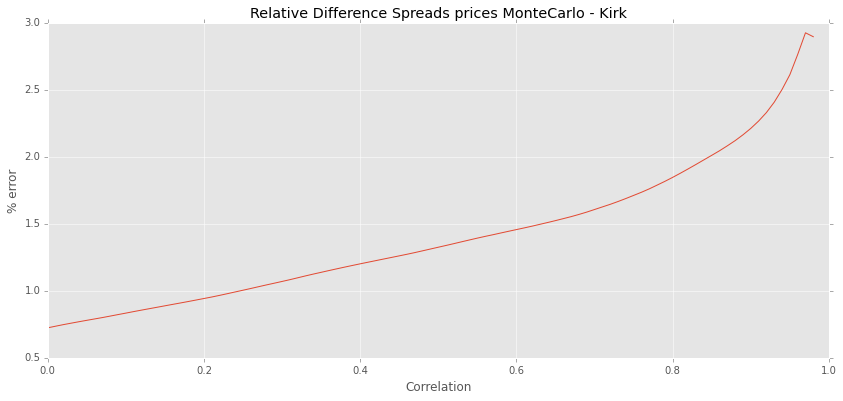

In [21]:
set_corr = [i/100. for i in range(99) ]
result_kirk = []
result_montecarlo = []
for rho in set_corr:
    SpreadCALL1 = kirk(40, 40, 3., 1., 0., .5, .5, rho, 1)
    result_kirk.append(SpreadCALL1.price)
    SpreadCALL2 = montecarlo(40, 40, 3., 1., 0., .5, .5, rho, 1, 100000)
    result_montecarlo.append(SpreadCALL2.price)
    
plt.figure(num=None, figsize=(14, 6))
plt.style.use('ggplot')
plt.plot(set_corr, 100*(np.array(result_montecarlo) - np.array(result_kirk))/np.array(result_kirk))
plt.title('Relative Difference Spreads prices MonteCarlo - Kirk')
plt.xlabel('Correlation')
plt.ylabel('% error');


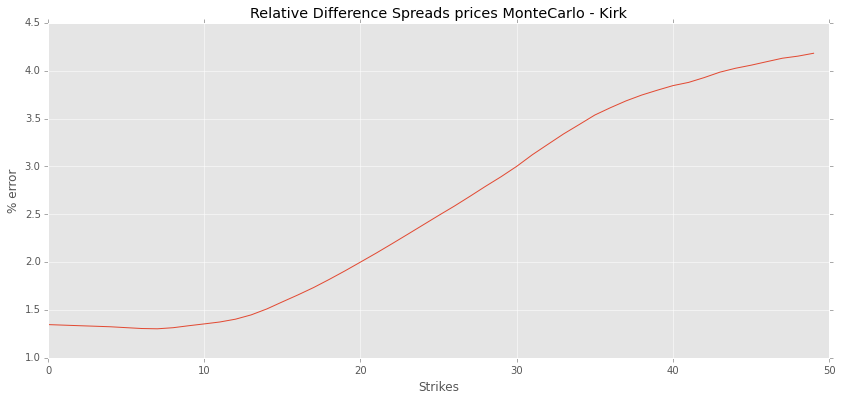

In [22]:
set_strikes = range(0, 50)
result_kirk = []
result_montecarlo = []
for strike in set_strikes:
    SpreadCALL1 = kirk(50, 50, strike, 1., 0., .5, .5, 0.5, 1)
    result_kirk.append(SpreadCALL1.price)
    SpreadCALL2 = montecarlo(50, 50, strike, 1., 0., .5, .5, 0.5, 1, 100000)
    result_montecarlo.append(SpreadCALL2.price)
    
plt.figure(num=None, figsize=(14, 6))
plt.style.use('ggplot')
plt.plot(set_strikes, 100*(np.array(result_montecarlo) - np.array(result_kirk))/np.array(result_kirk))
plt.title('Relative Difference Spreads prices MonteCarlo - Kirk')
plt.xlabel('Strikes')
plt.ylabel('% error');